<div align="center" style="line-height: 1.7;">
    <h2 style="font-weight: 600;"><strong>Q-Learning vs SARSA vs Dyna-Q</strong></h2>
</div> 

&nbsp;

This notebook compares the learning behavior, sample efficiency, and final
policies of three RL methods implemented in the project:
Q-Learning, SARSA(0), and Dyna-Q.

All methods are trained on the same GridWorld using identical hyperparameters
and seeds to ensure fairness.

---

If you would like to access the other notebooks, please reference the following hyperlinks

- [Q-Learning](notebooks/01_q_learning.ipynb)
- [SARSA notebook](notebooks/02_sarsa.ipynb)
- [Dyna-Q notebook](notebooks/03_dyna_q.ipynb)


## 1) Import & Environment Setup
This section imports all the necessary code and libraries. (There will be an `environment setup` in every notebook, it is necessary for the correct functioning of the algorithms and future analysis)

In [15]:
# ---  Notebook Setup ----------------------------------------------------
import sys, os
from pathlib import Path
from IPython import get_ipython
import importlib
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple
import numpy as np

GREEN = "\033[92m"; RED = "\033[91m"; RESET = "\033[0m"

try:
    root = Path.cwd()
    src_path = (root / "../src").resolve()

    # 1) Make sure local ../src wins over site-packages
    if str(src_path) not in sys.path:
        sys.path.insert(0, str(src_path))

    ip = get_ipython()
    if ip:
        ip.run_line_magic("load_ext", "autoreload")
        ip.run_line_magic("autoreload", "2")

    # 2) Import and *verify* we’re loading the right files
    import rl_capstone
    import rl_capstone.rl_algorithms as rla
    print("rl_capstone from:", getattr(rl_capstone, "__file__", "?"))
    print("rl_algorithms from:", getattr(rla, "__file__", "?"))

    # 3) Force a reload in case kernel already loaded the old one
    importlib.reload(rla)

    # 4) Now import the names (after reload)
    from rl_capstone import GridWorld, WorldSettings
    
    from rl_capstone.rl_algorithms import (
        TrainConfig,
        q_learning_train_with_logs,
        sarsa_train_with_logs,
        dyna_q_train_with_logs,
    )
    
    from rl_capstone.utils import (
        evaluate_policy,
        greedy_policy_from_0,
        plot_learning_curve,
        EpisodeLog,
        greedy_action,
        run_greedy_episode,
        rolling,
        idx_traj_to_rc_path,
        value_grid,
        plot_value_and_policy,
)

    print(f"{GREEN}Environment setup complete!{RESET}")

except Exception as e:
    print(f"{RED}Setup failed:{RESET}", e)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
rl_capstone from: /Users/houndsito/Documents/Development/github/fcampoverdeg/reinforcement_learning/src/rl_capstone/__init__.py
rl_algorithms from: /Users/houndsito/Documents/Development/github/fcampoverdeg/reinforcement_learning/src/rl_capstone/rl_algorithms.py
Environment setup complete!


## 2) Build & Preview the environment
This section is for visualization purposes, the user can see the world where the agent will be performing its tasks, this can be changed by the user by adding walls, pits, changing the position of the starting point and the goal, as well as the size of the Grid World.

(For more information on how to use the `GridWorld` class please check: [GridWorld](../src/rl_capstone/rl_algorithms.py))


States=121, Action4, Grid=11x11



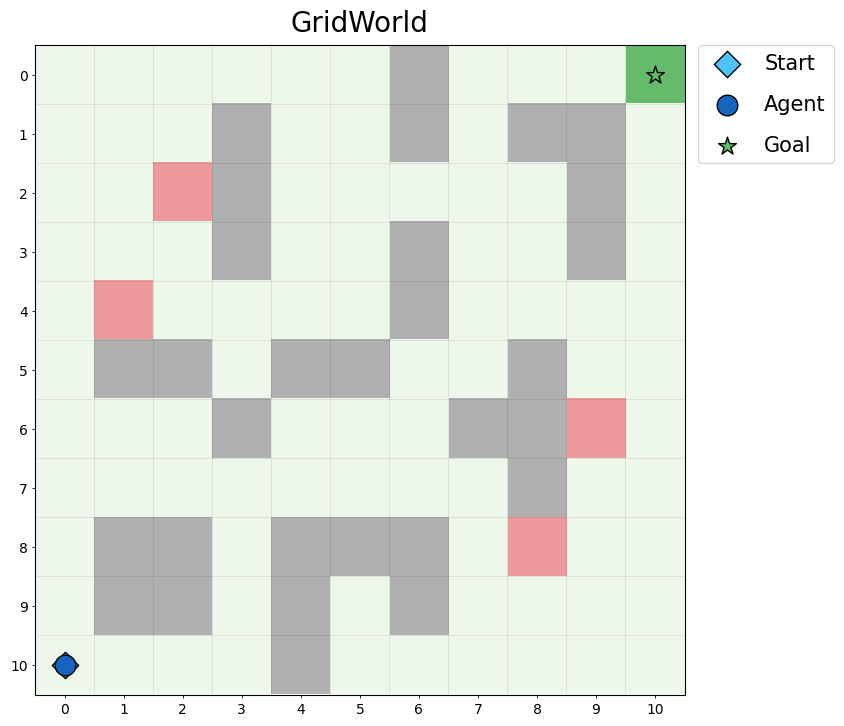

In [17]:
# Instantiate environment with your WorldSettings
settings = WorldSettings()      # tweak if you want a different map
env = GridWorld(settings)
env.seed(7)

print(f"\nStates={env.num_states}, Action{env.num_actions}, Grid={env.rows}x{env.cols}\n")

env.render(title="GridWorld")

## 3) Log Config

This section controls how often the log training progress is and how many episodes are run to measure greedy performance at each snapshot.

Users can change the limit of snapshots, episodes and seed, which will affect factors like: `Wind randomness`, `Transition noise`, `Length and returns of greedy evaluation episodes`.

In [18]:
# Tweak depending on user preferences
@dataclass
class LogConfig:
    snapshot_every: int = 40    # take a snapshot every N episodes
    eval_episodes: int = 5      # greedy evals per snapshot
    seed: Optional[int] = 7

print(f"{GREEN}Log Config Setup!{RESET}")

Log Config Setup!


## 4) Train Configuration + Log Config
In this section the user can set up the configurations needed for training the agent. As well as visualize how the agent is learning by plotting a `Learning Curve`, which shows the number of episodes with respect to the `Return` the agent experienced in the algorithm with the respective configurations.

In [20]:
# Same constants as other models
cfg = TrainConfig(
    episodes=750,
    max_steps=1000,
    alpha=0.10,
    gamma=0.99,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay_steps=10_000,
    seed=42,
    q_init=0.0
)

logcfg = LogConfig(snapshot_every=40, eval_episodes=5, seed=7)

## 5) Training Learning Models and Storage

For this step, we will run each algorithm and store the outputs in a dictionary called `results`.

results = 
    
    {
        "Q-Learning": {"Q": Q_q, "logs": logs_q},
        "SARSA":      {"Q": Q_s, "logs": logs_s},
        "Dyna-Q":     {"Q": Q_d, "logs": logs_d},
    }

In [21]:
results = {}

# ---- Train Q-Learning ---- #
try:
    print("Training Q-Learning...")
    Q_q, logs_q = q_learning_train_with_logs(env, cfg, logcfg)
    results["Q-Learning"] = {"Q": Q_q, "logs": logs_q}
except Exception as e:
    print(f"{RED}[ERROR] Q-Learning failed:{RESET}", e)
    Q_q = None

# ---- Train SARSA ---- #
try:
    print("Training SARSA...")
    Q_s, logs_s = sarsa_train_with_logs(env, cfg, logcfg)
    results["SARSA"] = {"Q": Q_s, "logs": logs_s}
except Exception as e:
    print(f"{RED}[ERROR] SARSA failed:{RESET}", e)
    Q_s = None

# ---- Train Dyna-Q ---- #
try:
    print("Training Dyna-Q...")
    Q_d, logs_d = dyna_q_train_with_logs(env, cfg, logcfg)
    results["Dyna-Q"] = {"Q": Q_d, "logs": logs_d}
except Exception as e:
    print(f"{RED}[ERROR] Dyna-Q failed:{RESET}", e)
    Q_d = None

# ---- Saving Q-Tables ---- #
print("\nSaving Q-tables...")
try:
    if Q_q is not None:
        np.save("../data/q_tables/Q_q.npy", Q_q)
    if Q_s is not None:
        np.save("../data/q_tables/Q_sarsa.npy", Q_s)
    if Q_d is not None:
        np.save("../data/q_tables/Q_dyna.npy", Q_d)

    print(f"{GREEN}Saved available Q-Tables successfully!{RESET}")
except Exception as e:
    print(f"{RED}[ERROR] Saving Q-tables failed:{RESET}", e)

print(f"{GREEN}Model training finished (with above warnings if any).{RESET}")


Training Q-Learning...
Training SARSA...
Training Dyna-Q...

Saving Q-tables...
Saved available Q-Tables successfully!
Model training finished (with above warnings if any).


## 6) Compare Results

To compare the `returns` we are going to use the method `moving_average` from [utils](../src/rl_capstone/utils.py).

In order to compare the plots created by each algorithm, we will be using the `rolling` method from [rl_algorithms](../src/rl_capstone/rl_algorithms.py).

### Compare Returns

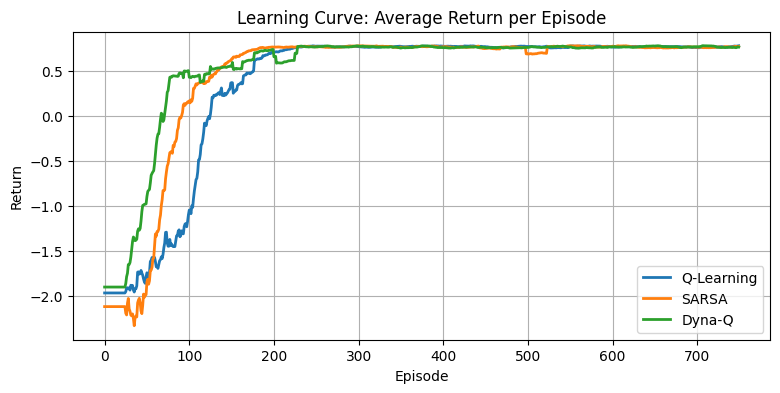

In [23]:
plt.figure(figsize=(9,4))
for name, res in results.items():
    returns = res["logs"]["returns"]
    smooth = rolling(returns, 25)
    plt.plot(smooth, label=name, linewidth=2)
plt.title("Learning Curve: Average Return per Episode")
plt.xlabel("Episode"); plt.ylabel("Return"); plt.grid(True); plt.legend()
plt.show()


### Compare Step per Episode

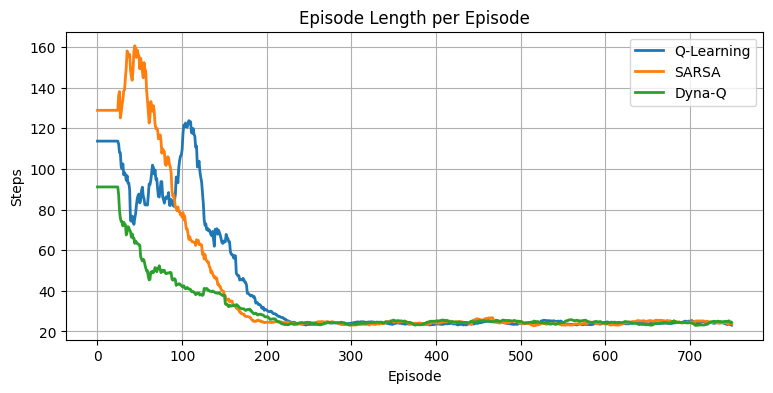

In [24]:
plt.figure(figsize=(9,4))
for name, res in results.items():
    steps = res["logs"]["steps"]
    smooth = rolling(steps, 25)
    plt.plot(smooth, label=name, linewidth=2)
plt.title("Episode Length per Episode")
plt.xlabel("Episode"); plt.ylabel("Steps"); plt.grid(True); plt.legend()
plt.show()


### Compare Final Greedy Performance

In [12]:
print("Final Greedy Policy Comparison:\n")
for name, res in results.items():
    Q = res["Q"]
    policy = greedy_policy_from_0(Q)
    mean_return, mean_length = evaluate_policy(
        env, policy, episodes=30, max_steps=cfg.max_steps, seed=7
    )
    print(f"{name:10s} | Return={mean_return:.3f} | Steps={mean_length:.1f}")


Final Greedy Policy Comparison:

Q-Learning | Return=0.776 | Steps=23.4
SARSA      | Return=0.777 | Steps=23.3
Dyna-Q     | Return=0.774 | Steps=23.6


## 7) Compare Final Greedy Path

This section prints the last outcome from the algorithms, showing the "most" optimal output. It provides the average `result` and `steps` the agent took during the algorithm.

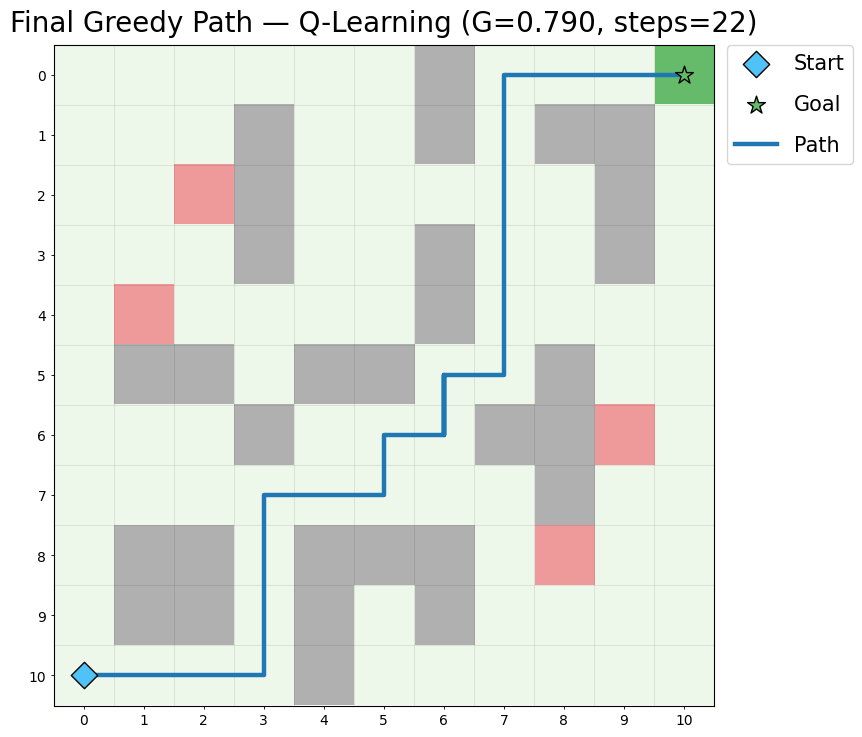

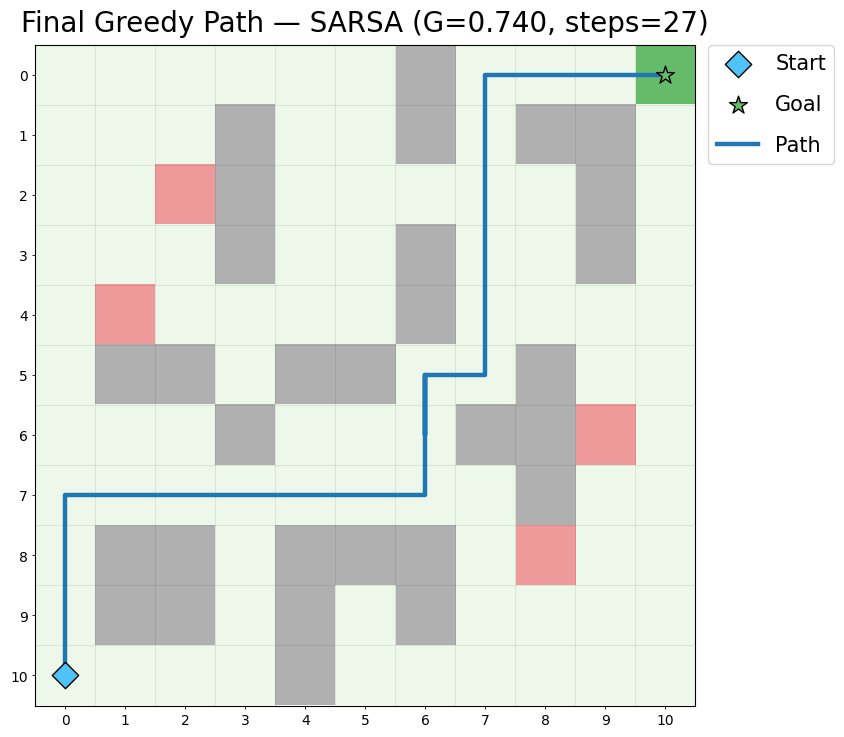

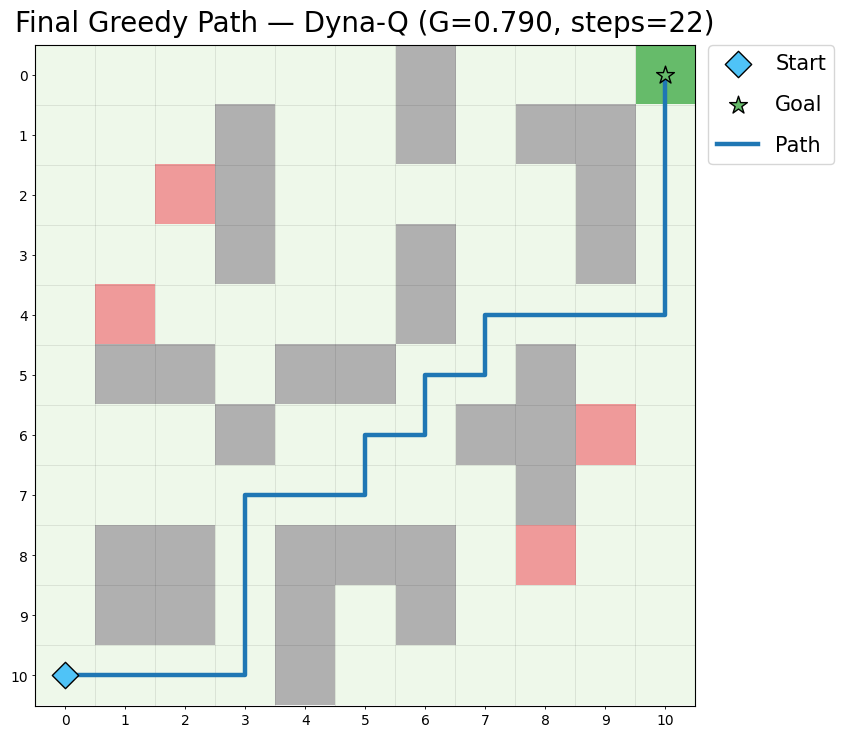

In [25]:
# Final Optimal Greedy Paths
G_final_q,      traj_final_q      = run_greedy_episode(env, Q_q,      max_steps=cfg.max_steps)
G_final_sarsa,  traj_final_sarsa  = run_greedy_episode(env, Q_s,      max_steps=cfg.max_steps)
G_final_dyna_q, traj_final_dyna_q = run_greedy_episode(env, Q_d,      max_steps=cfg.max_steps)

# Q-Learning final path
env.reset()
env.render(
    path=idx_traj_to_rc_path(env, traj_final_q),
    show_agent=False,
    title=f"Final Greedy Path — Q-Learning (G={G_final_q:.3f}, steps={len(traj_final_q)-1})"
)

# SARSA final path
env.reset()
env.render(
    path=idx_traj_to_rc_path(env, traj_final_sarsa),
    show_agent=False,
    title=f"Final Greedy Path — SARSA (G={G_final_sarsa:.3f}, steps={len(traj_final_sarsa)-1})"
)

# Dyna-Q final path
env.reset()
env.render(
    path=idx_traj_to_rc_path(env, traj_final_dyna_q),
    show_agent=False,
    title=f"Final Greedy Path — Dyna-Q (G={G_final_dyna_q:.3f}, steps={len(traj_final_dyna_q)-1})"
)


## 8) Policy / Value heatmap with arrows

Heat maps are used to visualize what is the trajectory that the agent took the most in order to find the "most" optimal greedy path.

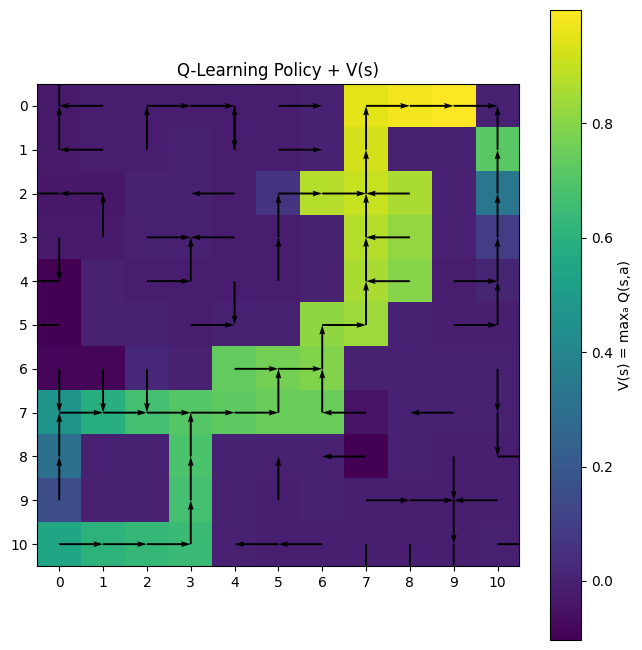

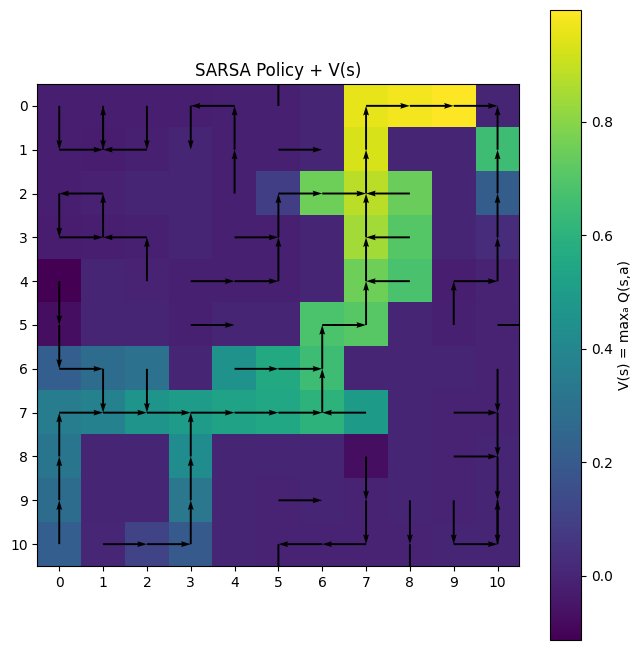

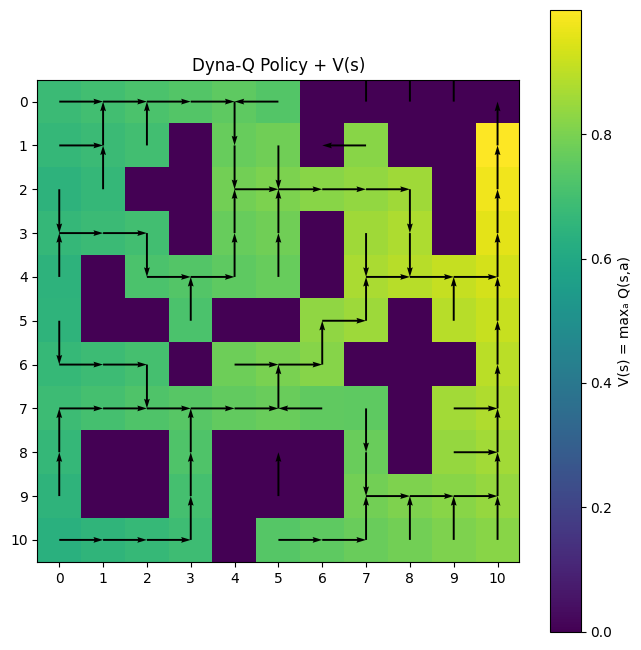

In [26]:
plot_value_and_policy(env, Q_q, "Q-Learning Policy + V(s)")
plot_value_and_policy(env, Q_s, "SARSA Policy + V(s)")
plot_value_and_policy(env, Q_d, "Dyna-Q Policy + V(s)")

---

## **Conclusion**

### **Experimental setup**
All three methods: Q-Learning (off-policy TD), SARSA(0) (on-policy TD), and Dyna-Q (model-based with planning), were trained on the same 11×11 stochastic GridWorld with walls, pits, and wind (≈10% chance of a sideways move).
We used identical hyperparameters across methods (same α, γ, ε-schedule, number of episodes and max steps) and a shared logging interface so learning curves and policies are directly comparable.

### **Learning behaviour & sample efficiency**
* **Dyna-Q learns fastest:**
In the return curves, Dyna-Q’s performance (green) ramps up sharply in the first ~50 episodes and reaches near-optimal returns long before the other two methods. In the steps-per-episode plot it quickly drives episode length down toward ~20 steps, indicating that planning updates are accelerating the propagation of value information.

* **SARSA is in the middle:**
SARSA (orange) learns more slowly than Dyna-Q but faster than Q-Learning. Its episode lengths and returns improve smoothly, reflecting its on-policy nature: it updates toward the value of the actually followed ε-greedy policy, which tends to be a bit more conservative.

* **Q-Learning lags but eventually catches up:**
Q-Learning (blue) has the slowest improvement early on and needs more episodes to reach the same return plateau. This is visible in both plots: returns take longer to rise and steps take longer to shrink. This is consistent with off-policy updates which can be more “aggressive” but require more experience to stabilize under stochastic dynamics.


Overall, **all three methods eventually reach similar performance**, but **Dyna-Q clearly dominates in sample efficiency** (return vs. training episodes / steps).

### **Final Greedy Policies & Paths**
Final evaluation of greedy policies over 50 test episodes gave:

| **Model**  | **Return Avg** | **Steps AVG** |
|:-----------:|:------------:|:-----------:|
| **Q-Learning** | Return=0.777 | Steps=23.3 |
| **SARSA**      | Return=0.776 | Steps=23.4 |
| **Dyna-Q**     | Return=0.775 | Steps=23.5 |

So,  
* Average **returns and path lengths are essentially identical**, all three methods learn very similar near-optimal policies.
  
* The **final greedy paths** plotted show this vividly:

    * Q-Learning reaches the goal in 25 steps in that particular rollout.
    
    * SARSA and Dyna-Q both find a 21 step route.
    
    * Paths differ slightly in early turns but all successfully avoid pits and weave around walls to the goal


The value-function heatmaps and policy-arrow visualizations also show that all three methods converge to almost the same value landscape and greedy action choices, especially along the main corridor from start to goal.

### **High-Level conclusion**
* **Early in training**, Dyna-Q is clearly more sample efficient: it achieves good returns and short paths with far fewer real environment interactions.
  
* **By the end of training**, all three methods produce comparably good greedy policies in this environment.

* The results match the theoretical expectations:
   * Dyna-Q gains from planning when the model is reasonably accurate.
     
   * Q-Learning and SARSA eventually catch up with enough experience, despite using only model-free updates.

---


---

<style>
    .button {
        background-color: #3b3b3b;
        color: white;
        padding: 25px 60px;
        border: none;
        border-radius: 12px;
        cursor: pointer;
        font-size: 30px;
        transition: background-color 0.3s ease;
    }

    .button:hover {
        background-color: #45a049;
        transform: scale(1.05);
    }
    
</style>

<div style=" text-align: center; margin-top:20px;">
    
  <a href="03_dyna_q.ipynb">
    <button class="button">
      ⬅️ Prev: Dyna-Q
    </button>
  </a>
  <span style="display:inline-block; width:200px;"></span>
  <a href="05_k_sweep.ipynb">
    <button class="button">
      Next: K Sweeping Dyna-Q ➡️
    </button>
  </a>
  
</div>
